In [2]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 

In [3]:
train = pd.read_excel('DST_BIL54_train.xlsx', index_col=0).T
Y = train['Drivmidler i alt']
X = np.arange(2018, 2018 + len(Y)/12 -1/12,  1/12)

In [4]:
f = lambda x: np.array([[1], [x]])


In [5]:
X_N = np.arange(-len(X)+1, 1)
X_N = np.hstack((np.ones((len(X_N), 1)), X_N.reshape(-1, 1)))

In [6]:
L = np.array([[1, 0], [1, 1]])
L, f(0)

(array([[1, 0],
        [1, 1]]),
 array([[1],
        [0]]))

In [7]:
Y = np.array(Y).reshape(-1, 1)

In [10]:
def F(n, lambda_=1):
    assert n > 0
    F_n = np.zeros((2, 2))
    for j in range(n):
        F_n += lambda_**j * f(-j) @ f(-j).T
    return F_n

def h(n, lambda_=1):
    assert n > 0
    h_n = np.zeros((2, 1))
    for j in range(n): 
        h_n += lambda_**j * f(-j) * Y[n-j-1] 
    return h_n
    

In [11]:
F(2) + f(-2) @ f(-2).T

array([[ 3., -3.],
       [-3.,  5.]])

In [12]:
F(3)

array([[ 3., -3.],
       [-3.,  5.]])

In [13]:
# sanity check 
X_N[-3:].T @ X_N[-3:]

array([[ 3., -3.],
       [-3.,  5.]])

In [14]:
X_N[-5:].T @ Y[:5]

array([[ 11898867.],
       [-23725564.]])

In [15]:
h(1)

array([[2367154.],
       [      0.]])

In [16]:
F(1), h(1)

(array([[1., 0.],
        [0., 0.]]),
 array([[2367154.],
        [      0.]]))

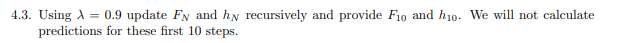

In [17]:
lambda_ = 0.9

Fi = F(1, lambda_=lambda_)
for i in range(1, 10):
    # FN+1 = FN + lambda**N  * f(-N) @ f(-N).T 
    Fi = Fi + lambda_**i * f(-i) @ f(-i).T

hi = h(1, lambda_=lambda_)
for i in range(2, 11):
    hi = lambda_ * np.linalg.inv(L) @ hi + f(0) * Y[i-1]



In [18]:
Fi

array([[  6.5132156 , -23.75109638],
       [-23.75109638, 137.46023515]])

In [19]:
hi

array([[ 15628556.81637141],
       [-56709555.93933485]])

In [20]:
h(10, 0.9)

array([[ 15628556.81637141],
       [-56709555.93933486]])

In [21]:
F(10, 0.9)

array([[  6.5132156 , -23.75109638],
       [-23.75109638, 137.46023515]])

In [22]:
F(59, 0.9)

array([[   9.98003322,  -88.64225888],
       [ -88.64225888, 1615.87659385]])

In [23]:
# sanity checks 
assert (F(10, 0.9).flatten().round(2) == Fi.flatten().round(2)).all()
assert (h(10, 0.9).flatten().round(2) == hi.flatten().round(2)).all()

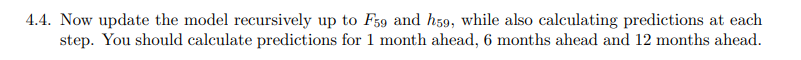

In [48]:
lambda_ = 0.9

Fi = F(1, lambda_=lambda_)
hi = h(1, lambda_=lambda_)
for i in range(1, 10):
    Fi = Fi + lambda_**i * f(-i) @ f(-i).T
    hi = lambda_ * np.linalg.inv(L) @ hi + f(0) * Y[i]


In [49]:

preds_1 = np.zeros(len(Y)+1) * np.nan
preds_6 = np.zeros(len(Y)+6) * np.nan
preds_12 = np.zeros(len(Y)+12) * np.nan


for i in range(10, 59):

    #FN+1 = FN + lambda**N  * f(-N) @ f(-N).T 
    Fi = Fi + lambda_**i * f(-i) @ f(-i).T

    hi = lambda_ * np.linalg.inv(L) @ hi + f(0) * Y[i]

    Thetai = np.linalg.inv(Fi) @ hi
    
    preds_1[i+1] = f(1).T @ Thetai
    preds_6[i+6] = f(6).T @ Thetai
    preds_12[i+12] = f(12).T @ Thetai




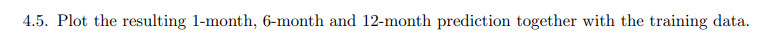

In [50]:
# align preds_1 with Y
df1 = pd.DataFrame({'Y': np.hstack((Y.flatten(), np.nan)) , 'preds_1': preds_1})
df6 = pd.DataFrame({'Y': np.hstack((Y.flatten(), [np.nan]*6)) , 'preds_6': preds_6})
df12 = pd.DataFrame({'Y': np.hstack((Y.flatten(), [np.nan]*12)) , 'preds_12': preds_12})

In [51]:
np.arange(0, len(Y)+14, 12)

array([ 0, 12, 24, 36, 48, 60, 72])

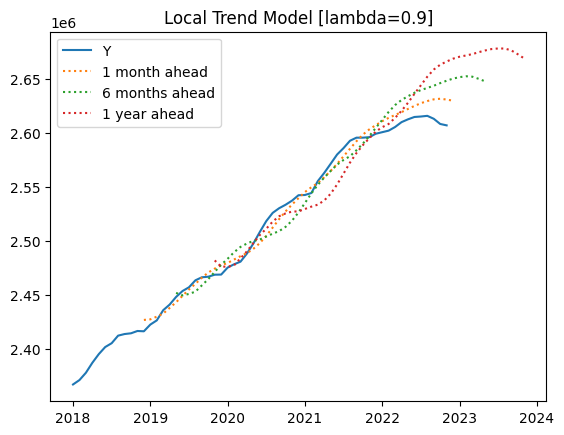

In [52]:
plt.plot(df1['Y'], label='Y')
plt.plot(df1['preds_1'], label='1 month ahead', linestyle=':')
plt.plot(df6['preds_6'], label='6 months ahead', linestyle=':')
plt.plot(df12['preds_12'], label='1 year ahead', linestyle=':')

# # set xticks

plt.xticks(np.arange(0, len(Y)+14, 12), np.arange(2018, 2025))
# set title 
plt.title('Local Trend Model [lambda=0.9]')

plt.legend()
# save plot
plt.savefig('local_trend_model.png')

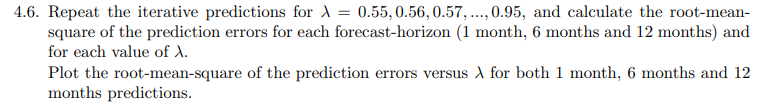

In [53]:
lambdas = np.arange(0.55, 0.96, 0.01)

In [54]:

rmses_1 = []
rmses_6 = []
rmses_12 = []

y = np.hstack((np.array(Y).flatten(), [np.nan]*12)) 

for lambda_ in lambdas:

    Fi = F(1, lambda_=lambda_)
    hi = h(1, lambda_=lambda_)
   
    for j in range(1, 10):
        Fi = Fi + lambda_**j * f(-j) @ f(-j).T
        hi = lambda_ * np.linalg.inv(L) @ hi + f(0) * Y[j]

    preds_1 = np.zeros(len(Y)+1) * np.nan
    preds_6 = np.zeros(len(Y)+6) * np.nan
    preds_12 = np.zeros(len(Y)+12) * np.nan

    for i in range(10, 59):
        # FN+1 = FN + lambda**N  * f(-N) @ f(-N).T 
        Fi = Fi + lambda_**i * f(-i) @ f(-i).T

        hi = lambda_ * np.linalg.inv(L) @ hi + f(0) * Y[i]

        Thetai = np.linalg.inv(Fi) @ hi

        preds_1[i+1] = f(1).T @ Thetai
        preds_6[i+6] = f(6).T @ Thetai
        preds_12[i+12] = f(12).T @ Thetai

    errors_1 = preds_1 - y[:len(preds_1)]
    rmse_1 = np.sqrt(np.mean(errors_1[~np.isnan(errors_1)]**2))
    rmses_1.append(rmse_1)

    errors_6 = preds_6 - y[:len(preds_6)]
    rmse_6 = np.sqrt(np.mean(errors_6[~np.isnan(errors_6)]**2))
    rmses_6.append(rmse_6)

    errors_12 = preds_12 - y[:len(preds_12)]
    rmse_12 = np.sqrt(np.mean(errors_12[~np.isnan(errors_12)]**2))
    rmses_12.append(rmse_12)

    
    

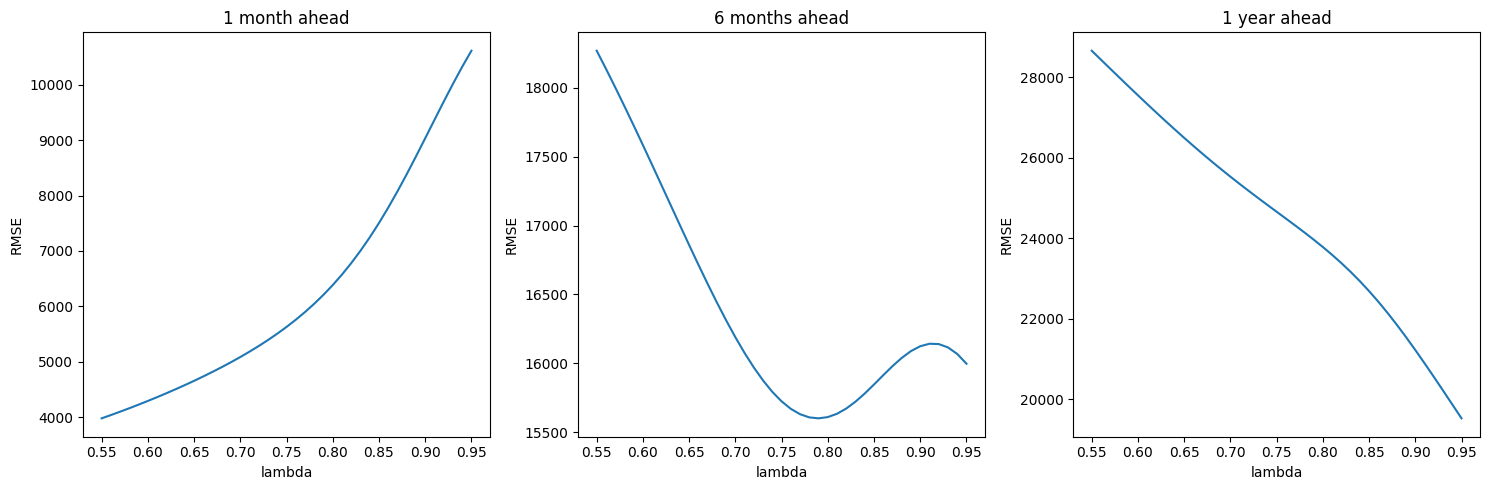

In [55]:
# get the rmse into 3 differnt plots side by side 

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(lambdas, rmses_1)
ax[0].set_title('1 month ahead')
ax[0].set_xlabel('lambda')
ax[0].set_ylabel('RMSE')

ax[1].plot(lambdas, rmses_6)
ax[1].set_title('6 months ahead')
ax[1].set_xlabel('lambda')
ax[1].set_ylabel('RMSE')

ax[2].plot(lambdas, rmses_12)
ax[2].set_title('1 year ahead')
ax[2].set_xlabel('lambda')
ax[2].set_ylabel('RMSE')

plt.tight_layout()
plt.savefig('local_trend_model_rmses_diff_lambdas.png')


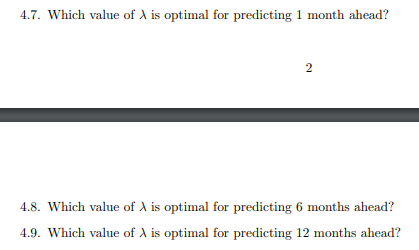

In [56]:
print(f'Best lambda for 1 month ahead: {lambdas[np.argmin(rmses_1)].round(2)}, with value: {np.min(rmses_1).round(2)}')
print(f'Best lambda for 6 months ahead: {lambdas[np.argmin(rmses_6)].round(2)}, with value: {np.min(rmses_6).round(2)}')
print(f'Best lambda for 1 year ahead: {lambdas[np.argmin(rmses_12)].round(2)}, with value: {np.min(rmses_12).round(2)}') 

Best lambda for 1 month ahead: 0.55, with value: 3980.51
Best lambda for 6 months ahead: 0.79, with value: 15600.56
Best lambda for 1 year ahead: 0.95, with value: 19528.35


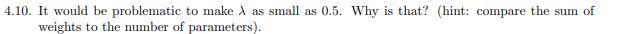

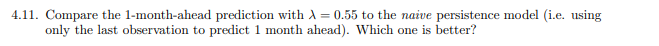

In [436]:

lambda_ = 0.55

Fi = F(10, lambda_=lambda_)
hi = h(10, lambda_=lambda_)

preds_1 = np.zeros(len(Y)+1) * np.nan

for i in range(10, 59):
    # FN+1 = FN + lambda**N  * f(-N) @ f(-N).T 
    Fi = Fi + lambda_**i * f(-i) @ f(-i).T

    hi = lambda_ * np.linalg.inv(L) @ hi + f(0) * Y[i]

    Thetai = np.linalg.inv(Fi) @ hi

    preds_1[i+1] = f(1).T @ Thetai

In [437]:
preds_dummy = np.zeros(len(Y)+1) * np.nan
preds_dummy[11:] = Y[10:].flatten()

In [438]:
df = pd.DataFrame({'Y': np.hstack((Y.flatten(), np.nan)), 'preds_dummy': preds_dummy, 'preds_1': preds_1})

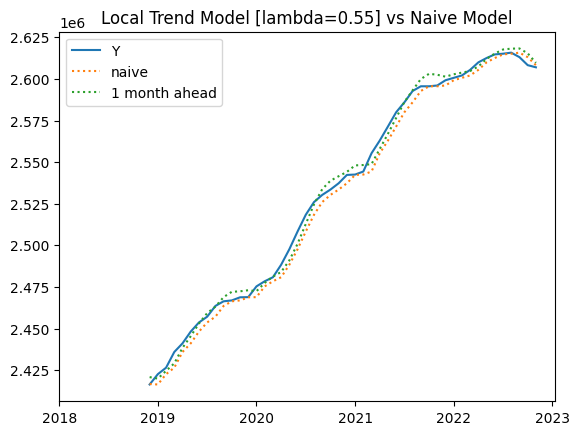

In [445]:
plt.plot(df['Y'], label='Y')
plt.plot(df['preds_dummy'], label='naive', linestyle=':')
plt.plot(df['preds_1'], label='1 month ahead', linestyle=':')

plt.xticks(np.arange(0, len(Y)+2, 12), np.arange(2018, 2024))
plt.title('Local Trend Model [lambda=0.55] vs Naive Model')

plt.legend()
plt.savefig('local_trend_model_55_naive.png')

In [442]:
df = df.dropna()
df['errors_1'] = df['Y'] - df['preds_1']
df['errors_dummy'] = df['Y'] - df['preds_dummy']


/tmp/ipykernel_2514/2583267003.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2514/2583267003.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [444]:
np.sqrt((df['errors_1']**2).mean()), np.sqrt((df['errors_dummy']**2).mean())

(3980.507987844184, 5330.43363229797)

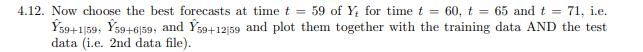

In [58]:
Fi = F(59, lambda_=0.55)
hi = h(59, lambda_=0.55)

Thetai = np.linalg.inv(Fi) @ hi


preds_60 = f(1).T @ Thetai
preds_65 = f(6).T @ Thetai
preds_71 = f(12).T @ Thetai

In [63]:
Y_test

2022M12    2607815
2023M01    2607714
2023M02    2608494
2023M03    2613610
2023M04    2618968
2023M05    2622297
2023M06    2626739
2023M07    2628145
2023M08    2630093
2023M09    2630495
2023M10    2627021
2023M11    2628746
Name: Drivmidler i alt, dtype: int64

In [71]:
test = pd.read_excel('DST_BIL54_test.xlsx', index_col=0).T
Y_test = test['Drivmidler i alt']
X_test = np.arange(X[-1] + 1/12, 2024-2/12,  1/12)


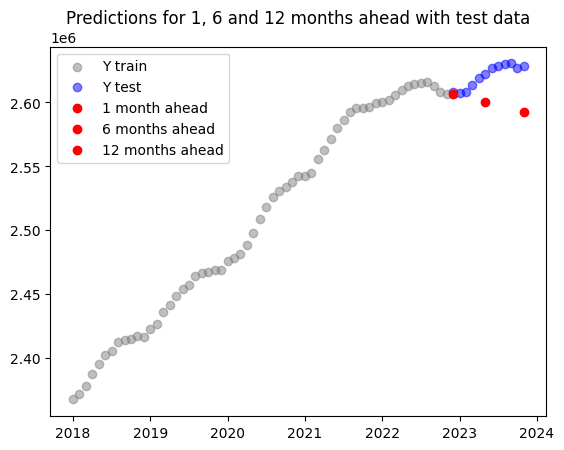

In [95]:
plt.scatter(x=X, y=Y, label='Y train', alpha=0.5, color='gray', marker='o')
plt.scatter(x=X_test, y=Y_test, label='Y test', alpha=0.5, color='blue', marker='o')

plt.scatter(x=X[-1] + 1/12, y=preds_60, label='1 month ahead', color='red')
plt.scatter(x=X[-1] + 6/12, y=preds_65, label='6 months ahead', color='red')
plt.scatter(x=X[-1] + 12/12, y=preds_71, label='12 months ahead', color='red')

plt.legend()
plt.title('Predictions for 1, 6 and 12 months ahead with test data')
plt.savefig('local_trend_model_test.png')

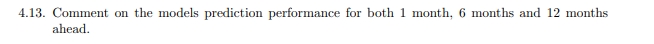